Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 128)     2816        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 700, 22)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 700, 150)     0           embedding[0][0]                  
                                                                 input_2[0][0]         

44/44 [==============================] - 638s 15s/step - loss: 0.1963 - accuracy: 0.9281 - myaccuracy: 0.7646
Epoch 38/100
44/44 [==============================] - 633s 14s/step - loss: 0.1943 - accuracy: 0.9288 - myaccuracy: 0.7668
Epoch 39/100
44/44 [==============================] - 637s 14s/step - loss: 0.1923 - accuracy: 0.9295 - myaccuracy: 0.7693
Epoch 40/100
44/44 [==============================] - 639s 15s/step - loss: 0.1901 - accuracy: 0.9302 - myaccuracy: 0.7715
Epoch 41/100
44/44 [==============================] - 645s 15s/step - loss: 0.1882 - accuracy: 0.9310 - myaccuracy: 0.7742
Epoch 42/100
44/44 [==============================] - 639s 15s/step - loss: 0.1854 - accuracy: 0.9320 - myaccuracy: 0.7775
Epoch 43/100
44/44 [==============================] - 643s 15s/step - loss: 0.1843 - accuracy: 0.9325 - myaccuracy: 0.7789
Epoch 44/100
44/44 [==============================] - 635s 14s/step - loss: 0.1824 - accuracy: 0.9330 - myaccuracy: 0.7807
Epoch 45/100
44/44 [=========

l:\anaconda3\envs\cs286\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
l:\anaconda3\envs\cs286\lib\site-packages\ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


测试集的正确率： [0.63335103]


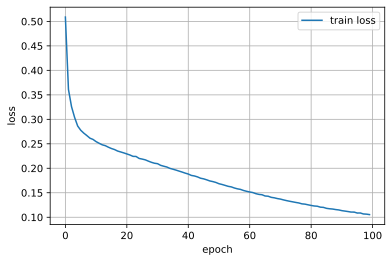

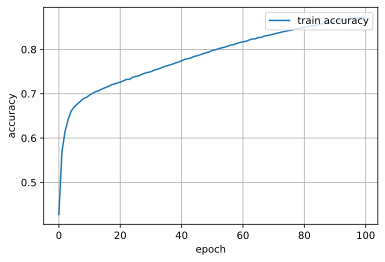

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"


# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
# # config.gpu_options.allow_growth = True
# session = tf.compat.v1.InteractiveSession(config=config)





import numpy as np
from numpy import array 
import pandas as pd
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, GRU, Conv1D, concatenate
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend as K
import tensorflow as tf
from keras import optimizers, initializers, constraints, regularizers
from keras.engine.topology import Layer
from tensorflow.keras.layers import Activation
from keras.layers import Flatten
import matplotlib.pyplot as plt
import pickle



# gpus = tf.config.experimental.list_physical_devices('GPU')
# # 对需要进行限制的GPU进行设置
# tf.config.experimental.set_virtual_device_configuration(gpus[0],
#                                                         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])


# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
 
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))




cb6133filename = "../data/cullpdb+profile_6133_filtered.npy.gz"
cb513 = "../data/cb513+profile_split1.npy.gz"
def load_augmented_data(npy_path, max_len):
    data = np.load(npy_path)
    residue_list = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq']
    q8_list = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T','NoSeq']
    data_reshape = data.reshape(data.shape[0], 700, -1)
    residue_onehot = data_reshape[:,:,0:22]
    residue_q8_onehot = data_reshape[:,:,22:31]
    profile = data_reshape[:,:,35:57]
    zero_arr = np.zeros((profile.shape[0], max_len - profile.shape[1], profile.shape[2]))
    profile_padded = np.concatenate([profile, zero_arr], axis=1)
    residue_array = np.array(residue_list)[residue_onehot.argmax(2)]
    q8_array = np.array(q8_list)[residue_q8_onehot.argmax(2)]
    residue_str_list = []
    q8_str_list = []
    for vec in residue_array:
        x = ''.join(vec[vec != 'NoSeq'])
        residue_str_list.append(x)
    for vec in q8_array:
        x = ''.join(vec[vec != 'NoSeq'])
        q8_str_list.append(x)
    id_list = np.arange(1, len(residue_array) + 1)
    len_list = np.array([len(x) for x in residue_str_list])
    train_df = pd.DataFrame({'id': id_list, 'len': len_list, 'input': residue_str_list, 'expected': q8_str_list})
    return train_df, profile_padded

def myaccuracy(y_true, y_pred):
    y = tf.argmax(y_true, axis =- 1)
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

# 简单onehot编码
def seq2onehot(seq, n):
    out = np.zeros((len(seq), maxlen_seq, n)) # （氨基酸序列条数，700，22（onehot的维度））
    for i in range(len(seq)): # i是第几条氨基酸序列的序号
        for j in range(maxlen_seq): # j是第i条氨基酸序列的第几个氨基酸的序号，1---700
            out[i, j, seq[i, j]] = 1 # 懂了，seq[i,j]这个值是多少（x），我们就在第几(x)个位置填1，这个值只能有22种可能性
    return out

counter = 0
# prints the results
def print_results(x, y_, revsere_decoder_index, counter,test_df):
    Ans['id'][counter] = test_df['id'][counter]
    # print("prediction: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    Ans['expected'][counter] = str(onehot_to_seq(y_, revsere_decoder_index).upper())

#
def seq2ngrams(seqs, n = 1):
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])


maxlen_seq = 700
train_df, X_aug_train = load_augmented_data(cb6133filename,maxlen_seq)
train_input_seqs, train_target_seqs = train_df[['input', 'expected']][(train_df.len <= maxlen_seq)].values.T
test_df, X_aug_test = load_augmented_data(cb513,maxlen_seq)
test_input_seqs, test_target_seqs = test_df[['input','expected']][(test_df.len <= maxlen_seq)].values.T






train_input_grams = seq2ngrams(train_input_seqs)
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(train_input_grams)
tokenizer_decoder = Tokenizer(char_level = True)
tokenizer_decoder.fit_on_texts(train_target_seqs)

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1


train_input_data = tokenizer_encoder.texts_to_sequences(train_input_grams)
X_train = sequence.pad_sequences(train_input_data, maxlen = maxlen_seq, padding = 'post')
train_target_data = tokenizer_decoder.texts_to_sequences(train_target_seqs)
train_target_data = sequence.pad_sequences(train_target_data, maxlen = maxlen_seq, padding = 'post')
y_train = to_categorical(train_target_data)


test_input_grams = seq2ngrams(test_input_seqs)
test_input_data = tokenizer_encoder.texts_to_sequences(test_input_grams)
X_test = sequence.pad_sequences(test_input_data, maxlen = maxlen_seq, padding = 'post')
test_target_data = tokenizer_decoder.texts_to_sequences(test_target_seqs)
test_target_data = sequence.pad_sequences(test_target_data, maxlen = maxlen_seq, padding = 'post')
test_target_data = seq2onehot(test_target_data,n_tags)
# y_test = to_categorical(test_target_data)




input = Input(shape = (maxlen_seq,))
input2 = Input(shape=(maxlen_seq,22))

x = Embedding(input_dim = n_words, output_dim = 128, input_length = maxlen_seq)(input)
x = concatenate([x,input2],axis=2)
z = Conv1D(64, 11, strides=1, padding='same')(x)
w = Conv1D(64, 7, strides=1, padding='same')(x)
x = concatenate([x,z],axis=2)
x = concatenate([x,w],axis=2)
z = Conv1D(64, 5, strides=1, padding='same')(x)
w = Conv1D(64, 3, strides=1, padding='same')(x)
x = concatenate([x,z],axis=2)
x = concatenate([x,w],axis=2)
x = Bidirectional(LSTM(units = 128, return_sequences = True))(x)

y = TimeDistributed(Dense(n_tags, activation = "softmax"))(x)

model = Model([input,input2], y)
model.summary()
model.compile(optimizer = 'RMSprop', loss = "categorical_crossentropy", metrics = ["accuracy", myaccuracy])
# history = model.fit([X_train,X_aug_train], y_train, batch_size = 32, epochs = 30, validation_data = ([X_test,X_aug_test], y_test), verbose = 1)
history = model.fit([X_train,X_aug_train], y_train, batch_size = 128, epochs = 100, verbose = 1)
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}
# acc = model.evaluate([X_test,X_aug_test], y_test)
# print (acc)
y_test_pred = model.predict([X_test,X_aug_test])
np.save('cb513_test_prob_6.npy', y_test_pred)
counter = 0
Ans = pd.DataFrame(0,index = np.arange(len(X_test)), columns = ['id','expected'])
for i in range(len(X_test)):
    print_results(X_test[i], y_test_pred[i], revsere_decoder_index,counter,test_df)
    counter+=1
Ans.to_csv('cb513_test_6.csv',index = False)


testaccseq=myaccuracy(test_target_data,y_test_pred)
testacc=np.sum(testaccseq)/testaccseq.shape
print('测试集的正确率：',testacc)


# Save the model as a JSON format，把模型结构和参数权重保存下来
model.save_weights("cb513_weights_1.h5")
with open("model_1.json", "w") as json_file:
    json_file.write(model.to_json())

# Save training history for parsing，把训练过程保存下来
with open("history_1.pkl", "wb") as hist_file:
    pickle.dump(history.history, hist_file)
    
    
# model.load_weights("cb513_weights_1.h5")
# with open("history_1.pkl",'rb') as f:
#     data = pickle.load(f)

# 画图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# 画loss图
plt.plot(history.history['loss'],label='train loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.savefig('train_loss.png', dpi=500, bbox_inches='tight')
plt.show()
# 画正确率图
plt.plot(history.history['myaccuracy'],label='train accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="upper right")
plt.savefig('train_accuracy.png', dpi=500, bbox_inches='tight')
plt.show()